$\textbf{Development: TRC Time Correction}$

Create a uniform sampling rate TRC file for testing.

In [1]:
import numpy as np
from biomech.processing.trc import *

In [2]:
# hand markers: 'X7', 'Y7', 'Z7' (RHP)

In [3]:
# use test file
test_trc_body = pd.read_csv('2609_01.trc', skiprows=4, sep='\t').rename(columns={'Unnamed: 0': 'Frame', 'Unnamed: 1': 'Time'}).dropna(axis=1, how='all')

# update time column
    # uniform grid of time values: 0.002 seconds apart
test_trc_body['Time'] = np.arange(0, test_trc_body.shape[0] * 0.0021, 0.0021)

$\textit{Butterworth Filter}$

- __Final Setup__: [18 Hz](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://commons.nmu.edu/cgi/viewcontent.cgi?article=2479&context=isbs), second order, zero-lag Butterworth low-pass filter to remove noise but prserve amplitude in signal.
- Lower frequencies and higher orders were found to reduce peak hand velocity, which may have the effect of reducing downstream torque

In [25]:
from scipy.signal import butter, filtfilt

In [26]:
def butter_lowpass_filter(
        data: pd.DataFrame, 
        columns: Union[list, str], 
        cutoff: float = 18, 
        fs: float = 480.0, 
        order: int = 2
) -> pd.DataFrame:
    """
    Apply a zero-phase Butterworth low-pass filter to biomechanics marker data.

    **Args**:
    `data` (pd.DataFrame): Input DataFrame with marker position columns.
    `columns` (str or list of str): Column(s) to filter.
    `cutoff` (float): Cutoff frequency in Hz. Default is 13.4 Hz.
    `fs` (float): Sampling frequency in Hz. Default is 480 Hz.
    `order` (int): Order of the Butterworth filter. Default is 4.

    Returns:
    `pd.DataFrame`: Filtered DataFrame with the same index and filtered columns.
    """
    
    # 
    if isinstance(columns, str):
        columns = [columns]

    # filtering params
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(N=order, Wn=normal_cutoff, btype='low', analog=False)

    # setup filtered df
    filtered_df = data.copy()

    # iterate through columns
    for col in columns:
        x = data[col].values
        x_filtered = filtfilt(b, a, x, method="pad")
        filtered_df[f'{col}_filtered'] = x_filtered

    return filtered_df

<Axes: title={'center': 'Raw and Filtered Hand Marker Data'}, xlabel='Frame', ylabel='Marker Position (mm)'>

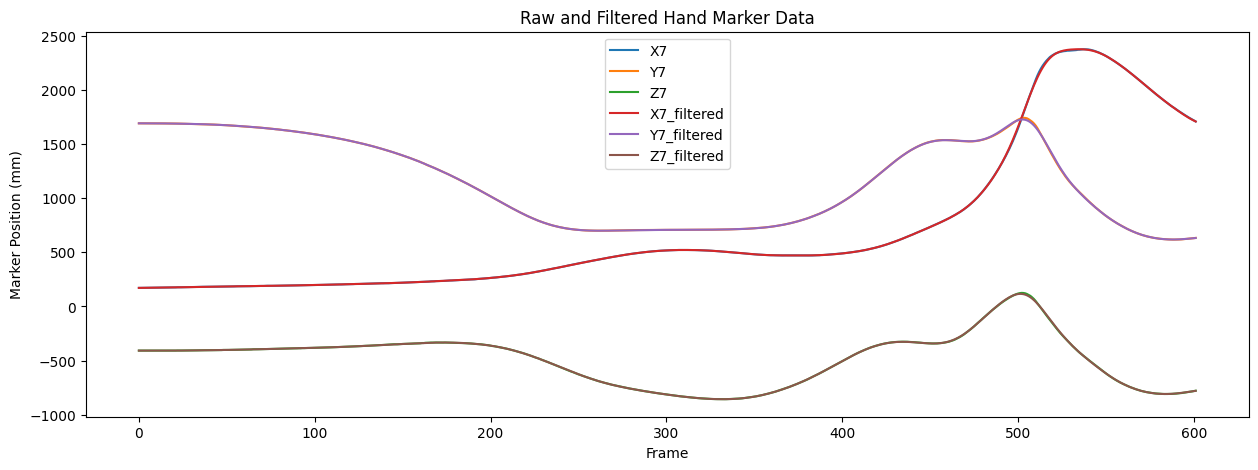

In [27]:
# apply filter to data
test_filter = butter_lowpass_filter(
    data=test_trc_body, 
    columns=['X7', 'Y7', 'Z7'], 
    cutoff=18, 
    fs=480.0, 
    order=2
)

# plot raw and filtered data on same plot
test_filter.plot(
    y=['X7', 'Y7', 'Z7', 'X7_filtered', 'Y7_filtered', 'Z7_filtered'], 
    figsize=(15, 5), 
    title='Raw and Filtered Hand Marker Data',
    xlabel='Frame',
    ylabel='Marker Position (mm)'
)

$\textit{Deriviatives}$

- Five point central differences (e.g., for marker speed)

In [30]:
from typing import Union

def diff_five_point(
        data: pd.DataFrame, 
        columns: Union[str, list[str]],
        sampling_rate: float = 480.0
) -> pd.DataFrame:
    """
    Compute 5-point central difference for one or more columns in a DataFrame,
    assuming constant sampling rate.

    **Args**:
    - `data` (pd.DataFrame): Input DataFrame.
    - `columns` (str or list of str): Column(s) to differentiate.
    - `sampling_rate` (float): Samples per second (Hz). Default is 480 Hz.

    **Returns**:
    pd.DataFrame: New DataFrame with derivative columns (same index).
    """
    if isinstance(columns, str):
        columns = [columns]

    h = 1.0 / sampling_rate
    deriv_data = data.copy()

    # iterate through columns
    for col in columns:
        y = data[col].values
        dydt = np.full_like(y, np.nan, dtype=np.float64)

        # handle first two points with forward difference
        dydt[0] = (y[1] - y[0]) / h
        dydt[1] = (y[2] - y[1]) / (2 * h)

        # compute interior point derivatives using 5-point central difference
        for i in range(2, len(data) - 2):
            dydt[i] = (-y[i+2] + 8*y[i+1] - 8*y[i-1] + y[i-2]) / (12 * h)

        # handle last two points with backward difference
        dydt[-2] = (y[-1] - y[-3]) / (2 * h)
        dydt[-1] = (y[-1] - y[-2]) / h

        deriv_data[f'd{col}_dt'] = dydt

    return deriv_data

<Axes: >

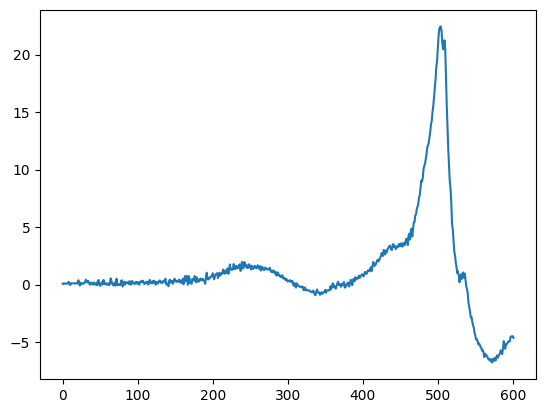

In [31]:
# get raw derivative
test_deriv_raw = diff_five_point(test_trc_body, columns=['X7', 'Y7', 'Z7'])
test_deriv_filtered = diff_five_point(test_filter, columns=['X7_filtered', 'Y7_filtered', 'Z7_filtered'])

# plot x-traj marker speed
# (test_hand_markers['X7'] / 1000).plot()
(test_deriv_raw['dX7_dt'] / 1000).plot()

<Axes: >

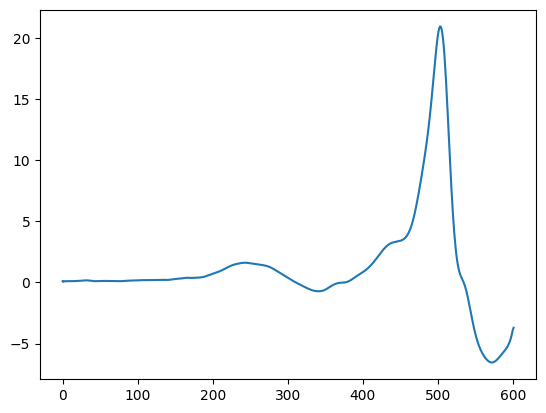

: 

In [ ]:
(test_deriv_filtered['dX7_filtered_dt'] / 1000).plot()

$\textbf{Close Connection}$

In [ ]:
aws_connection.close()